In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('C:/Users/shpva/OneDrive/Desktop/IndependentStudy_CIS5369/McCoy_Totals.csv',index_col='Date',parse_dates=True)
#df['Date'] = pd.to_datetime(df['Date'])
df1 = df.filter(['Date','MCCOY.ELEC.BTUS.DAY'])

In [31]:
df1.head()

,MCCOY.ELEC.BTUS.DAY
Date,
2021-10-01,9971163.0
2021-10-02,8757426.0
2021-10-03,9152674.0
2021-10-04,11600000.0
2021-10-05,11500000.0


<AxesSubplot:xlabel='Date'>

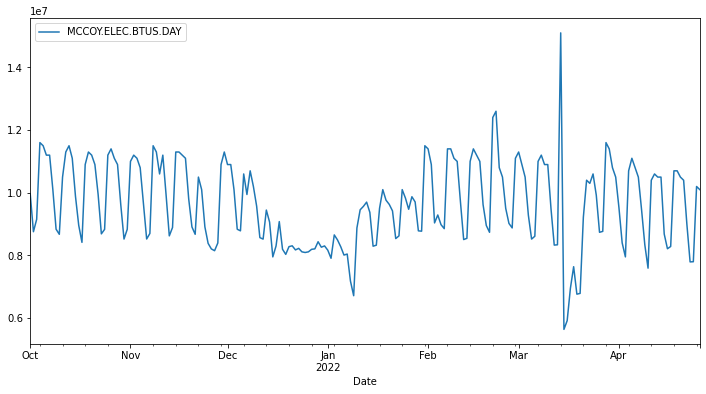

In [16]:
df1.plot(figsize=(12,6))

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

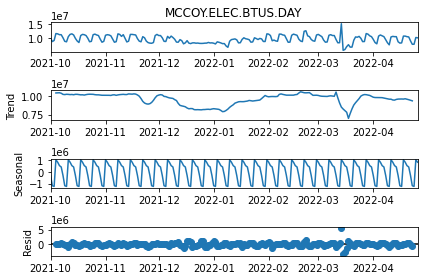

In [18]:
results = seasonal_decompose(df1['MCCOY.ELEC.BTUS.DAY'])
results.plot();

In [20]:
len(df1)

208

In [76]:
train = df1.iloc[:190]
test = df1.iloc[190:]

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [78]:
df1.head(),df1.tail()

(            MCCOY.ELEC.BTUS.DAY
 Date                           
 2021-10-01            9971163.0
 2021-10-02            8757426.0
 2021-10-03            9152674.0
 2021-10-04           11600000.0
 2021-10-05           11500000.0,
             MCCOY.ELEC.BTUS.DAY
 Date                           
 2022-04-22            9002116.0
 2022-04-23            7795156.0
 2022-04-24            7800369.5
 2022-04-25           10200000.0
 2022-04-26           10100000.0)

In [79]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [80]:
scaled_train[:10]

array([[0.45768024],
       [0.32934051],
       [0.37113377],
       [0.62991236],
       [0.61933843],
       [0.58761664],
       [0.58761664],
       [0.47130338],
       [0.33786225],
       [0.32061945]])

In [81]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [154]:
# define generator
n_input = 7 #seasonality component
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [155]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.45768024 0.32934051 0.37113377 0.62991236 0.61933843 0.58761664
 0.58761664]
Predict this y: 
 [[0.47130338]]


In [156]:
X.shape

(1, 7, 1)

In [157]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [158]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [159]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [160]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               40800     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(generator,epochs=50)

Epoch 1/50
178/178 [==============================] - 15s 6ms/step - loss: 0.0275
Epoch 2/50
178/178 [==============================] - 1s 7ms/step - loss: 0.0207
Epoch 3/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0188
Epoch 4/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0188
Epoch 5/50
178/178 [==============================] - 1s 7ms/step - loss: 0.0195
Epoch 6/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0189
Epoch 7/50
178/178 [==============================] - 1s 7ms/step - loss: 0.0186
Epoch 8/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0185
Epoch 9/50
178/178 [==============================] - 1s 7ms/step - loss: 0.0170
Epoch 10/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0172
Epoch 11/50
178/178 [==============================] - 1s 6ms/step - loss: 0.0164
Epoch 12/50
178/178 [==============================] - 1s 7ms/step - loss: 0.0165
Epoch 13/50
178/178 [===

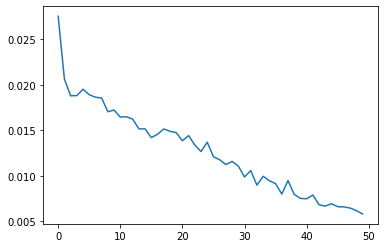

In [162]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [163]:
last_train_batch = scaled_train[-12:]

In [164]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [165]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 305ms/step


array([[0.34207952]], dtype=float32)

In [166]:
scaled_test[0]

array([0.28549491])

In [167]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [168]:
test_predictions

[array([0.34207952], dtype=float32),
 array([0.34352702], dtype=float32),
 array([0.5399589], dtype=float32),
 array([0.5729986], dtype=float32),
 array([0.56175125], dtype=float32),
 array([0.5395504], dtype=float32),
 array([0.46863496], dtype=float32),
 array([0.37590867], dtype=float32),
 array([0.36764812], dtype=float32),
 array([0.5570928], dtype=float32),
 array([0.5503512], dtype=float32),
 array([0.5496805], dtype=float32),
 array([0.53314906], dtype=float32),
 array([0.46960104], dtype=float32),
 array([0.38893622], dtype=float32),
 array([0.37600547], dtype=float32),
 array([0.52589345], dtype=float32),
 array([0.5120917], dtype=float32)]

In [169]:
test.head()

,MCCOY.ELEC.BTUS.DAY,Predictions
Date,,
2022-04-09,8342768.5,8.798724e+06
2022-04-10,7594869.0,8.787458e+06
2022-04-11,10400000.0,1.139727e+07
2022-04-12,10600000.0,1.111430e+07
2022-04-13,10500000.0,1.094055e+07


In [170]:
true_predictions = scaler.inverse_transform(test_predictions)

In [171]:
test['Predictions'] = true_predictions

<ipython-input-171-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

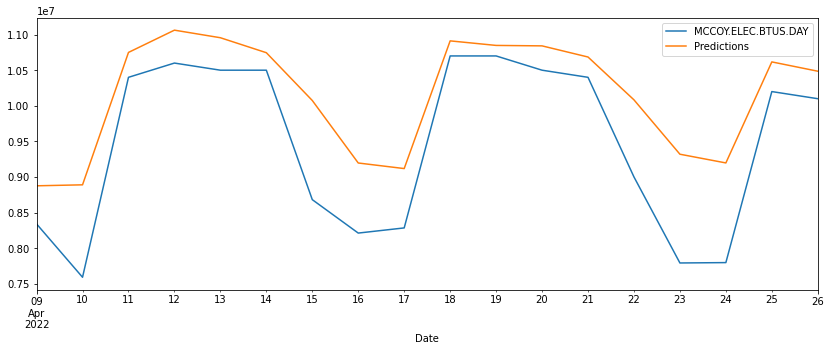

In [172]:
test.plot(figsize=(14,5))

In [173]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['MCCOY.ELEC.BTUS.DAY'],test['Predictions']))
print(rmse)

823491.4055952362
